# Bootstrap aggregating

## Basic bagging
One approach to get many estimators is to use the same training algorithm for every predictor and train them on different random subsets of the training set. When sampling is performed with replacement, this method is called *bagging* (short for *bootstrap aggregating*). When sampling is performed without replacement, it is called *pasting*.

Consider the following example. The dataset is the one we used in Chpater 3: `make_moon`. We split the dataset into training and test sets.

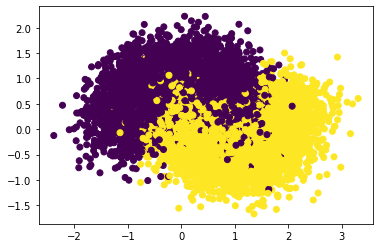

In [47]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=10000, noise=0.4, random_state=42)
plt.scatter(x=X[:, 0], y=X[:, 1], c=y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

We would like to sample from the dataset to get some smaller minisets. We will use `sklearn.model_selection.ShuffleSplit` to perform the action. 

The output of `ShuffleSplit` is a generator. To get the index out of it we need a `for` loop. You may check out the following code. 

Note that `ShuffleSplit` is originally used to shuffle data into training and test sets. We would only use the shuffle function out of it, so we will set `test_size` to be `1` and use `_` later in the `for` loop since we won't use that part of the information.

What we finally get is a generator `rs` that produces indexes of subsets of `X_train` and `y_train`. 

In [48]:
from sklearn.model_selection import ShuffleSplit
n_trees = 1000
n_instances = 100
rs = ShuffleSplit(n_splits=n_trees, test_size=1, train_size=n_instances).split(X_train)

Now we would like to generate a list of Decision Trees. We could use the hyperparameters we get from Chapter 3. We train each tree over a certain mini set, and then evaluate the trained model over the test set. The average accuracy is around 80%.

Note that `rs` is a generator. We put it in a for loop, and during each loop it will produce a list of indexes which gives a subset. We will directly train our model over the subset and use it to predict the test set. The result of each tree is put in the list `y_pred_list` and the accuracy is stored in the list `acc_list`. The mean of the accuracy is then computed by `np.mean(acc_list)`.

In [49]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import numpy as np

y_pred_list = list()
acc_list = list()
for mini_train_index, _ in rs:
    X_subset = X_train[mini_train_index]
    y_subset = y_train[mini_train_index]
    clf_ind = DecisionTreeClassifier(min_samples_split=2, max_leaf_nodes=17)
    clf_ind.fit(X_subset, y_subset)
    y_pred = clf_ind.predict(X_test)
    y_pred_list.append(y_pred)
    acc_list.append(accuracy_score(y_pred, y_test))

np.mean(acc_list)


0.8046993333333332

Now for each test data, we actually have `n_trees=1000` predicted results. We can treat it as the options from 1000 exports and would like to use the majority as our result. For this purpose we would like to use `mode()` which will find the most frequent entry.

In [50]:
from scipy.stats import mode
voting = np.array(y_pred_list)
y_pred_mode, _ = mode(voting, axis=0)
y_pred_mode = y_pred_mode.reshape(-1)

Since the output of `mode` is a tuple where the first entry is a 2D array, we need to reshape `y_pred_mode`. This is the result using this voting system. Then we are able to compute the accuracy, and find that it is increased from the previous prediction.

In [51]:

accuracy_score(y_pred_mode, y_test)

0.874

## Some rough analysis
The point of `Bagging` is to let every classifier study part of the data, and then gather the opinions from everyone. If the performance are almost the same between individual classifers and the Bagging classifiers, this means that the majority of the individual classifiers have the same opinions. One possible reason is that the randomized subsets already catch the main features of the dataset that every individual classifiers behave similar.

### Case 1
Let us continue with the previous dataset. We start from using Decision Tree with `max_depth=1`. In other words each tree only split once.

In [52]:
n_trees = 500
n_instances = 1000
rs = ShuffleSplit(n_splits=n_trees, test_size=1, train_size=n_instances).split(X_train)
y_pred_list = list()
acc_list = list()
for mini_train_index, _ in rs:
    X_subset = X_train[mini_train_index]
    y_subset = y_train[mini_train_index]
    clf_ind = DecisionTreeClassifier(max_depth=1)
    clf_ind.fit(X_subset, y_subset)
    y_pred = clf_ind.predict(X_test)
    y_pred_list.append(y_pred)
    acc_list.append(accuracy_score(y_pred, y_test))
print('The mean of individual accuracy: {}'.format(np.mean(acc_list)))

voting = np.array(y_pred_list)
y_pred_mode, _ = mode(voting, axis=0)
y_pred_mode = y_pred_mode.reshape(-1)
print('The accuracy of the bagging classifier: {}'.format(accuracy_score(y_pred_mode, y_test)))

The mean of individual accuracy: 0.7903386666666666
The accuracy of the bagging classifier: 0.7933333333333333


The two accuracy has some differences, but not much. This is due to the fact that the sample size of the subset is too large: 1000 can already help the individual classifers to capture the major ideas of the datasets. Let us see the first 1000 data points. The scattering plot is very similar to that of the whole dataset shown above.

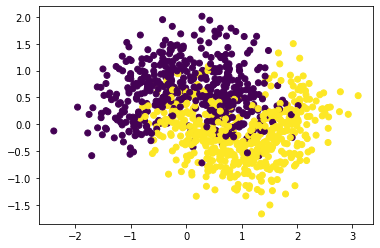

In [53]:
Npiece = 1000
plt.scatter(x=X[:Npiece, 0], y=X[:Npiece, 1], c=y[:Npiece])

### Case 2
If we reduce the sample size to be very small, for example, 20, the sampled subset will lose a lot of information and it will be much harder to capture the idea of the original dataset. See the scattering plot of the first 20 data points.

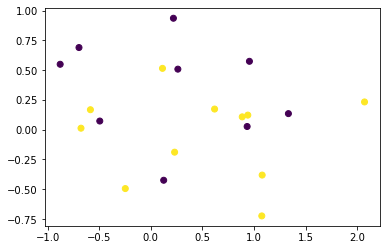

In [54]:
Npiece = 20
plt.scatter(x=X[:Npiece, 0], y=X[:Npiece, 1], c=y[:Npiece])

In this case, let us see the performance comparison between multiple decision trees and the bagging classifier.

In [55]:
n_trees = 500
n_instances = 20
rs = ShuffleSplit(n_splits=n_trees, test_size=1, train_size=n_instances).split(X_train)
y_pred_list = list()
acc_list = list()
for mini_train_index, _ in rs:
    X_subset = X_train[mini_train_index]
    y_subset = y_train[mini_train_index]
    clf_ind = DecisionTreeClassifier(max_depth=1)
    clf_ind.fit(X_subset, y_subset)
    y_pred = clf_ind.predict(X_test)
    y_pred_list.append(y_pred)
    acc_list.append(accuracy_score(y_pred, y_test))
print('The mean of individual accuracy: {}'.format(np.mean(acc_list)))

voting = np.array(y_pred_list)
y_pred_mode, _ = mode(voting, axis=0)
y_pred_mode = y_pred_mode.reshape(-1)
print('The accuracy of the bagging classifier: {}'.format(accuracy_score(y_pred_mode, y_test)))

The mean of individual accuracy: 0.7297666666666667
The accuracy of the bagging classifier: 0.822


This time you may see a significant increase in the performance.

## Using `sklearn`

`sklearn` provides `BaggingClassifier` to directly perform bagging or pasting. The code is as follows.

In [56]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(),
                            n_estimators=1000,
                            max_samples=100,
                            bootstrap=True)

In the above code, `bag_clf` is a bagging classifier, made of 500 `DecisionTreeClassifer`s, and is trained over subsets of size `100`. The option `bootstrap=True` means that it is bagging. If you would like to use pasting, the option is `bootstrap=False`.

This `bag_clf` also has `.fit()` and `.predict()` methods. It is used the same as our previous classifiers. Let us try the `make_moon` dataset.


In [57]:
bag_clf.fit(X_train, y_train)
y_pred_bag = bag_clf.predict(X_test)
accuracy_score(y_pred_bag, y_test)

0.8726666666666667

## OOB score
When we use `bagging`, it is possible that some of the training data are not used. In this case, we could record which data are not used, and just use them as the test set, instead of providing extra data for test. The data that are not used is called *out-of-bag* instances, or *oob* for short. The accuracy over the oob data is called the oob score.

We could set `oob_score=True` to enable the function when creating a `BaggingClassifier`, and use `.oob_score_` to get the oob score after training. 

In [58]:
bag_clf_oob = BaggingClassifier(DecisionTreeClassifier(),
                                n_estimators=1000,
                                max_samples=100,
                                bootstrap=True,
                                oob_score=True)
bag_clf_oob.fit(X_train, y_train)
bag_clf_oob.oob_score_

0.8628235294117647

## Random Forests
When the classifiers used in a bagging classifier are all Decision Trees, the bagging classifier is called a `random forest`. `sklearn` provide `RandomForestClassifier` class. It is almost the same as `BaggingClassifier` + `DecisionTreeClassifer`.


In [59]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=1000, max_leaf_nodes=17)
rnd_clf.fit(X_train, y_train)
y_pred_rnd = rnd_clf.predict(X_test)
accuracy_score(y_pred_rnd, y_test)

0.8746666666666667

When we use the Decision Tree as our base estimators, the class `RandomForestClassifier` provides more control over growing the random forest, with a certain optimizations. If you would like to use other estimators, then `BaggingClassifier` should be used.



### Extra-trees
When growing a Decision Tree, our method is to search through all possible ways to find the best split point that get the lowest Gini impurity. Anohter method is to use a random split. Of course a random tree performs much worse, but if we use it to form a random forest, the voting system can help to increase the accuracy. On the other hand, random split is much faster than a regular Decision Tree. 

This type of forest is called *Extremely Randomized Trees*, or *Extra-Trees* for short. We could modify the above random forest classifier code to implement the extra-tree algorithm. The key point is that we don't apply the Decision Tree algorithm to `X_subset`. Instead we perform a random split.

In [72]:
n_trees = 500
n_instances = 20
rs = ShuffleSplit(n_splits=n_trees, test_size=1, train_size=n_instances).split(X_train)
y_pred_list = list()
acc_list = list()
for mini_train_index, _ in rs:
    X_subset = X_train[mini_train_index]
    y_subset = y_train[mini_train_index]
    clf_ind = DecisionTreeClassifier(max_depth=1)
# random split
    i = np.random.randint(0, X_subset.shape[0])
    j = np.random.randint(0, X_subset.shape[1])
    split_threshold = X_subset[i, j]
    lsetindex = np.where(X_subset[:, j]<split_threshold)[0]

    if len(lsetindex) == 0:
        rsetindex = np.where(X_subset[:, j]>=split_threshold)
        rmode, _ = mode(y_subset[rsetindex])
        rmode = rmode[0]
        lmode = 1 - rmode
    else:
        lmode, _ = mode(y_subset[lsetindex])
        lmode = lmode[0]
        rmode = 1 - lmode
    y_pred = np.where(X_test[:, j] < split_threshold, lmode, rmode).reshape(-1)
# The above code is used to use the random split to classify the data points
    y_pred_list.append(y_pred)
    acc_list.append(accuracy_score(y_pred, y_test))
print('The mean of individual accuracy: {}'.format(np.mean(acc_list)))

voting = np.array(y_pred_list)
y_pred_mode, _ = mode(voting, axis=0)
y_pred_mode = y_pred_mode.reshape(-1)
print('The accuracy of the bagging classifier: {}'.format(accuracy_score(y_pred_mode, y_test)))

The mean of individual accuracy: 0.6285973333333333
The accuracy of the bagging classifier: 0.84


From the above example, you may find a significant increase in the performace from the mean individual accuracy to the Extra-tree classifier accuracy. The accuracy of the Extra-tree classifier is also very close to what we get from the original data points, although its base classifier is much simpler.

In `sklearn` there is an `ExtraTreesClassifier` to create such a classifier. It is hard to say which random forest is better beforehand. What we can do is to test and calculate the cross-validation scores (with grid search for hyperparameters tuning).

In [51]:
from sklearn.ensemble import ExtraTreesClassifier

ext_clf = ExtraTreesClassifier(n_estimators=1000, max_leaf_nodes=17)
ext_clf.fit(X_train, y_train)
y_pred_rnd = ext_clf.predict(X_test)
accuracy_score(y_pred_rnd, y_test)

0.842

In the above example, `RandomForestClassifier` and `ExtraTreesClassifier` get similar accuracy. However from the code below, you will see that in this example `ExtraTreesClassifier` is much faster than `RandomForestClassifier`.

In [52]:
from time import time
t0 = time()
rnd_clf = RandomForestClassifier(n_estimators=1000, max_leaf_nodes=17)
rnd_clf.fit(X_train, y_train)
t1 = time()
print('Random Frorest: {}'.format(t1 - t0))

t0 = time()
ext_clf = ExtraTreesClassifier(n_estimators=1000, max_leaf_nodes=17)
ext_clf.fit(X_train, y_train)
t1 = time()
print('Extremely Randomized Trees: {}'.format(t1 - t0))

Random Frorest: 3.9931533336639404
Extremely Randomized Trees: 1.4583396911621094



### Gini importance
After training a Decision Tree, we could look at each node. Each split is against a feature, which decrease the Gini impurity the most. In other words, we could say that the feature is the most important during the split.

Using the average Gini impurity decreased as a metric, we could measure the importance of each feature. This is called *Gini importance*. If the feature is useful, it tends to split mixed labeled nodes into pure single class nodes. 

In the case of random forest, since there are many trees, we might compute the weighted average of the Gini importance across all trees. The weight depends on how many times the feature is used in a specific node.

Using `RandomForestClassifier`, we can directly get access to the Gini importance of each feature by `.feature_importance_`. Please see the following example.

In [54]:
rnd_clf.fit(X_train, y_train)
rnd_clf.feature_importances_

array([0.44071222, 0.55928778])

In this example, you may see that the two features are relavely equally important, where the second feature is slightly more important since on average it decrease the Gini impurity a little bit more.